In [1]:
# Before running this file, activate the venv using "sklearn-venv\Scripts\activate"
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,validation_curve, learning_curve
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn import datasets


#for MV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scikitplot as skplt
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve
plt.style.use('ggplot')

# Using panda.io to read the dataset
unprocessed_data_X = pd.read_csv("heartdisease300.csv")
unprocessed_data_y = unprocessed_data_X.loc[:, "target"]

# Feature Selection using a chi-squared scoring function
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
feature_selection = SelectKBest(chi2, k=11)
processed_data_X = feature_selection.fit_transform(
    unprocessed_data_X, unprocessed_data_y)
processed_data_Y = processed_data_X[:, 10]
# Hyperparameters: score_func - chi2

# These features had the 3 lowest chi2 scores and will be excluded:
# fasting blood sugar > 120 mg/dl
# resting electrocardiographic results (values 0,1,2)
# number of major vessels (0-3) colored by flourosopy

# SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote_processed_data_X, smote_processed_data_Y = SMOTE(
).fit_resample(processed_data_X, processed_data_Y)
# Hyperparameters: sampling_strategy - auto = resampling only the minority class
# k_neighbors - default = 5

# 27 new entries were created by SMOTE to oversample the minority

# 70%/30% Training Test Split
processed_train_X, processed_test_X, processed_train_Y, processed_test_Y = train_test_split(
    processed_data_X, processed_data_Y, test_size=0.3)
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(
    smote_processed_data_X, smote_processed_data_Y, test_size=0.3)
# Hyperparameters: test_size - 30
# train_size - 70
# shuffle default = True


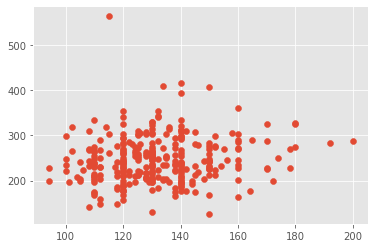

In [2]:
# print(unprocessed_data_X)
g1 = unprocessed_data_X.loc[:, "age":"target"]
plt.scatter('trestbps', 'chol', data=g1);

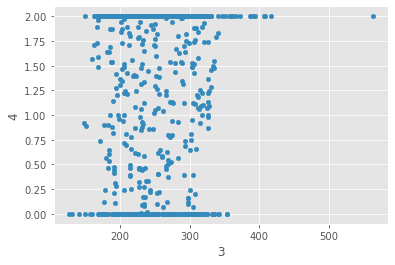

In [3]:
smoteDF = pd.DataFrame(smote_processed_data_X) # Convert SMOTE-treated data numpy array to DataFrame to use .loc
smoteDF.to_csv("SMOTEData.csv")

# print(smoteDF)
g2 = smoteDF.loc[1025:1051,:] # New data from SMOTE
# print (g2) 
smoteDF.plot(x=3, y=4, kind='scatter');

In [4]:
# RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

random_forest = RandomForestClassifier(n_estimators=10)

# RF w/ SMOTE
random_forest_smote = random_forest.fit(smote_train_X, smote_train_Y)
random_forest_smote_cv = cross_validate(
    random_forest_smote, smote_train_X, smote_train_Y)
print('---RANDOM FOREST---')
print('Random Forest w/ SMOTE Training Set Accuracy: ', end="")
print(np.mean(random_forest_smote_cv['test_score']))
print('Random Forest w/ SMOTE Test Set Accuracy: ', end="")
print(random_forest_smote.score(smote_test_X, smote_test_Y))

# RF w/o SMOTE
random_forest_processed = random_forest.fit(
    processed_train_X, processed_train_Y)
random_forest_processed_cv = cross_validate(
    random_forest_processed, processed_train_X, processed_train_Y)
print('Random Forest w/o SMOTE Training Accuracy: ', end="")
print(np.mean(random_forest_processed_cv['test_score']))
print('Random Forest w/o SMOTE Test Set Accuracy: ', end="")
print(random_forest_processed.score(processed_test_X, processed_test_Y))

rf_predicted_nosmote = random_forest_processed.predict(processed_test_X)
rf_predicted_smote = random_forest_smote.predict(smote_test_X)

# confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
rf_conf_matrix_nosmote = confusion_matrix(
    processed_test_Y, rf_predicted_nosmote)
print(rf_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
r_conf_matrix_smote = confusion_matrix(smote_test_Y, rf_predicted_smote)
print(r_conf_matrix_smote)

# scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y, rf_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y, rf_predicted_smote))

---RANDOM FOREST---
Random Forest w/ SMOTE Training Set Accuracy: 0.9912738367658276
Random Forest w/ SMOTE Test Set Accuracy: 0.991869918699187
Random Forest w/o SMOTE Training Accuracy: 0.8781838316722037
Random Forest w/o SMOTE Test Set Accuracy: 0.8901098901098901
confusion matrix


without smote


[[51  0  0  0  0]
 [ 0 19  0  0  0]
 [ 0  4  6  0  0]
 [ 0  0  3  4  0]
 [ 0  0  2  1  1]]


with smote


[[46  0  0  0  0]
 [ 0 49  0  0  0]
 [ 0  4 45  0  0]
 [ 0  0  4 47  0]
 [ 0  1  4 19 27]]


without smote
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        51
         1.0       0.83      1.00      0.90        19
         2.0       0.55      0.60      0.57        10
         3.0       0.80      0.57      0.67         7
         4.0       1.00      0.25      0.40         4

    accuracy                           0.89        91
   macro avg       0.83      0.68      0.71        91
weighted avg       0.90      0.89      0.88      

In [5]:
#copy the result put in train below
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(processed_test_X, processed_test_Y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1000000.0, 'gamma': 1e-07} with a score of 0.91


---SUPPORT VECTOR MACHINE---
SVM w/ SMOTE Test Set Accuracy: 1.0
SVM w/ SMOTE Training Set Accuracy: 1.0
SVM w/o SMOTE Test Set Accuracy: 1.0
SVM w/o SMOTE Training Set Accuracy: 1.0



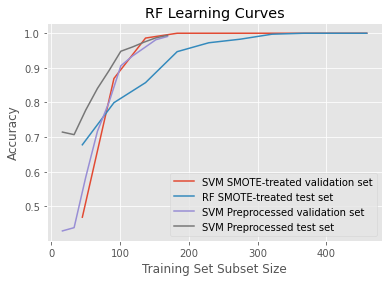

confusion matrix


without smote


[[51  0  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0  4]]


with smote


[[46  0  0  0  0]
 [ 0 49  0  0  0]
 [ 0  0 49  0  0]
 [ 0  0  0 51  0]
 [ 0  0  0  0 51]]


without smote
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        51
         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00         7
         4.0       1.00      1.00      1.00         4

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

with smote
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        46
         1.0       1.00      1.00      1.00        49
         2.0       1.00      1.00      1.00        49
         3.0       1.00      1.00  

In [6]:
#TODO: SVM
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

svm = SVC(kernel='rbf', gamma=0.0000001,C=1000000)

# SVM w/ SMOTE
svm_processed=svm.fit(smote_train_X, smote_train_Y)
svm_predicted_nosmote = svm.predict(processed_test_X)
print('---SUPPORT VECTOR MACHINE---')
print('SVM w/ SMOTE Test Set Accuracy: ', end="")
print(svm.score(smote_test_X, smote_test_Y))
print('SVM w/ SMOTE Training Set Accuracy: ', end="")
print(svm.score(smote_train_X, smote_train_Y))

# SVM w/o SMOTE
svm_smote = svm.fit(processed_data_X, processed_data_Y)
svm_predicted_smote = svm.predict(smote_test_X)

print('SVM w/o SMOTE Test Set Accuracy: ', end="")
print(svm.score(processed_test_X, processed_test_Y))
print('SVM w/o SMOTE Training Set Accuracy: ', end="")
print(svm.score(processed_train_X, processed_train_Y))
print()

#learning curve

train_sizes_abs, train_scores, test_scores = learning_curve(
    svm_smote,
    smote_train_X,
    smote_train_Y,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes_abs, train_scores_mean, label="RF SMOTE-treated training set")
plt.plot(train_sizes_abs, test_scores_mean,
         label="SVM SMOTE-treated validation set")

train_sizes_abs_test, train_scores, test_scores = learning_curve(
    svm_smote,
    smote_test_X,
    smote_test_Y,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes_abs, np.mean([train_scores_mean, test_scores_mean], axis=0),
         label="RF SMOTE-treated test set")

train_sizes_abs, train_scores, test_scores = learning_curve(
    svm_processed,
    processed_train_X,
    processed_train_Y,
    train_sizes=np.linspace(0.1, 1.0, 10)
)
# train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes_abs, train_scores_mean, label="RF Preprocessed training set")
plt.plot(train_sizes_abs, test_scores_mean,
         label="SVM Preprocessed validation set")

train_sizes_abs_test, train_scores, test_scores = learning_curve(
    svm_processed,
    processed_train_X,
    processed_train_Y,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes_abs, np.mean([train_scores_mean, test_scores_mean], axis=0),
         label="SVM Preprocessed test set")

plt.title("RF Learning Curves")
plt.xlabel("Training Set Subset Size")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

#confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
svc_conf_matrix_nosmote = confusion_matrix(processed_test_Y,svm_predicted_nosmote)
print(svc_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
svc_conf_matrix_smote = confusion_matrix(smote_test_Y,svm_predicted_smote)
print(svc_conf_matrix_smote)

#scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y,svm_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y,svm_predicted_smote))

In [7]:
#TODO: MV

# estimators for ensembling MV
estimators = [('RandomForest', rf), ('SVM', svm)]
ensemble_smote = VotingClassifier(estimators, voting='hard', weights=[1,1], n_jobs=-1) #hard voting, because we are doing MV
ensemble_smote.fit(smote_test_X, smote_test_Y)
results_smote = model_selection.cross_val_score(ensemble_smote, smote_test_X, smote_test_Y, scoring='accuracy')
print();
print("Validation accuracy for Ensembling w/ SMOTE: ", end="")
print(results_smote.mean())

# # TODO: Adjust MV Hyperparameters
# # Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters

y_pred = ensemble_smote.predict(smote_test_X)
print(classification_report(smote_test_Y, y_pred))

skplt.metrics.plot_confusion_matrix(smote_test_Y, y_pred, figsize=(10, 8))
plt.show()

# params = {'voting':['hard'], 
#           'weights':[(1,1)]}

# grid_smote = GridSearchCV(estimator=ensemble_smote, param_grid=params, cv=2)

# grid_smote.fit(smote_train_X, smote_train_Y)
# print("Best parameters for Ensembling + SMOTE: ", end="")
# print(grid_smote.best_params_)

#{'voting': 'hard', 'weights': (1, 1)}

# validation graph
param_range = np.arange(1,10,1, dtype=int)
train_scores, test_scores = validation_curve(
    VotingClassifier(estimators),
    smote_test_X,
    smote_test_Y,
    param_name="n_jobs",
    param_range=param_range,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,label="train", color="blue")
plt.plot(param_range, test_scores_mean,label="test", color="red")

plt.legend()
plt.show()

ensemble_proc = VotingClassifier(estimators, voting='hard', weights=[1,1], n_jobs=-1) #hard voting, because we are doing MV
ensemble_proc.fit(processed_test_X, processed_test_Y)
results_proc = model_selection.cross_val_score(ensemble_proc, processed_test_X, processed_test_Y, scoring='accuracy')
print();
print("Validation accuracy for Ensembling w/o SMOTE: ", end="")
print(results_proc.mean())

y_pred = ensemble_proc.predict(processed_test_X)
print(classification_report(processed_test_Y, y_pred))

skplt.metrics.plot_confusion_matrix(processed_test_Y, y_pred, figsize=(10, 8))
plt.show()

# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters
# params = {'voting':['hard'], 
#           'weights':[(1,1)]}

# grid_proc = GridSearchCV(estimator=ensemble_proc, param_grid=params, cv=2)

# grid_proc.fit(processed_train_X, processed_train_Y)
# print("Best parameters for Ensembling w/o SMOTE: ", end="")
# print(grid_proc.best_params_)

#{'voting': 'hard', 'weights': (1, 1)}

param_range = np.arange(1,10,1, dtype=int)
train_scores, test_scores = validation_curve(
    ensemble_proc,
    processed_test_X,
    processed_test_Y,
    param_name="n_jobs",
    param_range=param_range,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,label="train", color="blue")
plt.plot(param_range, test_scores_mean,label="test", color="red")

plt.legend()
plt.show()

# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# # Refer to MV documentation for possible parameter values

NameError: name 'rf' is not defined